### Packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import mean_absolute_error, r2_score
import gc
import difflib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score, log_loss
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
import re

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Load your features and labels
X = np.load("../eICU_data_handler/numpy_data_c2/Xstatic_train_local2.npy")  # or Xdynamic_train_c1.npy (flattened)
y = np.load("../eICU_data_handler/numpy_data_c2/y_train_c2.npy").astype(int)

# Flatten dynamic if needed
if X.ndim == 3:
    X = X.reshape(X.shape[0], -1)

clf = LogisticRegression(max_iter=1000).fit(X, y)
probs = clf.predict_proba(X)[:, 1]
auc = roc_auc_score(y, probs)

print(f"Leakage AUC (LogReg on raw features): {auc:.4f}")

Leakage AUC (LogReg on raw features): 0.5247


# **Importing datasets and preprocessing**

TRYING MATCHING STATIC FEATURES ONLY.

In [3]:
Xs_tr_c1 = np.load("../MIMIC_data_handler/numpy_data_c1/Xstatic_train_c1.npy")    
Xs_te_c1 = np.load("../MIMIC_data_handler/numpy_data_c1/Xstatic_test_c1.npy")     

Xd_tr_c1 = np.load("../MIMIC_data_handler/numpy_data_c1/Xdynamic_train_c1.npy")   
Xd_te_c1 = np.load("../MIMIC_data_handler/numpy_data_c1/Xdynamic_test_c1.npy")    

y_tr_c1 = np.load("../MIMIC_data_handler/numpy_data_c1/y_train_c1.npy")      
y_te_c1 = np.load("../MIMIC_data_handler/numpy_data_c1/y_test_c1.npy")          

Xs_tr_c2 = np.load("../eICU_data_handler/numpy_data_c2/Xstatic_train_c2.npy")    
Xs_te_c2 = np.load("../eICU_data_handler/numpy_data_c2/Xstatic_test_c2.npy")     

Xd_tr_c2 = np.load("../eICU_data_handler/numpy_data_c2/Xdynamic_train_c2.npy")   
Xd_te_c2 = np.load("../eICU_data_handler/numpy_data_c2/Xdynamic_test_c2.npy")    

y_tr_c2 = np.load("../eICU_data_handler/numpy_data_c2/y_train_c2.npy")      
y_te_c2 = np.load("../eICU_data_handler/numpy_data_c2/y_test_c2.npy")          

In [4]:
print("Xs_tr_c1:", Xs_tr_c1.shape)
print("Xs_te_c1:", Xs_te_c1.shape)
print("Xd_tr_c1:", Xd_tr_c1.shape)
print("Xd_te_c1:", Xd_te_c1.shape)
print("y_tr_c1:", y_tr_c1.shape)
print("y_te_c1:", y_te_c1.shape)

Xs_tr_c1: (27585, 10)
Xs_te_c1: (6897, 10)
Xd_tr_c1: (27585, 24, 205)
Xd_te_c1: (6897, 24, 205)
y_tr_c1: (27585,)
y_te_c1: (6897,)


In [5]:
print("Xs_tr_c2:", Xs_tr_c2.shape)
print("Xs_te_c2:", Xs_te_c2.shape)
print("Xd_tr_c2:", Xd_tr_c2.shape)
print("Xd_te_c2:", Xd_te_c2.shape)
print("y_tr_c2:", y_tr_c2.shape)
print("y_te_c2:", y_te_c2.shape)

Xs_tr_c2: (34137, 9)
Xs_te_c2: (8535, 9)
Xd_tr_c2: (34137, 24, 123)
Xd_te_c2: (8535, 24, 123)
y_tr_c2: (34137,)
y_te_c2: (8535,)


# **Training**

Inspiration from https://github.com/ziyuan-shen/LSTM_MIMICIII/tree/master/Code which took inspiration from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0211057

In [6]:
class ICUTimeSeriesDataset(Dataset):
    def __init__(self, X_static, X_dynamic, y):
        # expect X_static: (N, S), X_dynamic: (N, T, M), y: (N,)
        self.Xs = torch.tensor(X_static, dtype=torch.float32)
        self.Xd = torch.tensor(X_dynamic, dtype=torch.float32)
        self.y  = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.Xs[idx], self.Xd[idx], self.y[idx]

In [7]:
train_ds1 = ICUTimeSeriesDataset(Xs_tr_c1, Xd_tr_c1, y_tr_c1)
test_ds1  = ICUTimeSeriesDataset(Xs_te_c1, Xd_te_c1, y_te_c1)

train_loader1 = DataLoader(train_ds1, batch_size=64, shuffle=True,  num_workers=0)
test_loader1 = DataLoader(test_ds1,  batch_size=64, shuffle=False, num_workers=0)

train_ds2 = ICUTimeSeriesDataset(Xs_tr_c2, Xd_tr_c2, y_tr_c2)
test_ds2  = ICUTimeSeriesDataset(Xs_te_c2, Xd_te_c2, y_te_c2)

train_loader2 = DataLoader(train_ds2, batch_size=64, shuffle=True,  num_workers=0)
test_loader2 = DataLoader(test_ds2,  batch_size=64, shuffle=False, num_workers=0)
# batch size is datasamples process at the same time during training we try 64

In [8]:
class TestLSTM(nn.Module):
    def __init__(self, n_static, n_dynamic, lstm_hidden=32, mlp_hidden=16):
        super().__init__()
        # dynamic branch
        self.lstm = nn.LSTM(input_size=n_dynamic,
                            hidden_size=lstm_hidden,
                            num_layers=1,
                            batch_first=True)
        
        # static branch
        self.static_net = nn.Sequential(
            nn.Linear(n_static, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.6),
        )
        # combined head
        self.head = nn.Sequential(
            nn.Linear(lstm_hidden + mlp_hidden, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1)
            # nn.Sigmoid() # USE ONLY if we have BCEloss
        )

    def forward(self, xs, xd):
        # xd: (batch, T, M) -> LSTM -> hidden state
        _, (h_n, _) = self.lstm(xd)     # h_n: (num_layers, batch, hidden)
        dyn_feat = h_n[-1]              # (batch, hidden)
        stat_feat = self.static_net(xs) # (batch, mlp_hidden)
        out = torch.cat([dyn_feat, stat_feat], dim=1)
        return self.head(out)

## First MIMIC data only.

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

CHANGE DEATH TO 1 so pos_weight works correctly.

In [10]:
majority_class = np.bincount(y_tr_c1.astype(int)).argmax()
baseline_acc = (y_te_c1 == majority_class).mean()

print("Baseline majority-class accuracy client 1:", baseline_acc)

Baseline majority-class accuracy client 1: 0.9314194577352473


In [11]:
# Pos_weights due to class imbalance.
counts1 = np.bincount(y_tr_c1.astype(int))
neg1, pos1 = counts1[0], counts1[1]

pos_weight1 = torch.tensor(neg1/pos1, dtype=torch.float32, device=device)

criterion1 = nn.BCEWithLogitsLoss(pos_weight=pos_weight1)
#criterion1 = nn.BCELoss()

print("Mimic dynamic shape:", Xd_tr_c2.shape)

Mimic dynamic shape: (34137, 24, 123)


In [12]:
pos_weight1

tensor(0.0736, device='mps:0')

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Instantiate:
model1 = TestLSTM(
    n_static = Xs_tr_c1.shape[1],
    n_dynamic= Xd_tr_c1.shape[2],
).to(device)

optimizer1 = optim.Adam(model1.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler1 = ReduceLROnPlateau(optimizer1, mode='min', factor=0.5, patience=3, verbose=True)

Here we just compute all criterions for MIMIC, eICU and both.

In [14]:
def train_epoch(loader):
    model1.train()
    running_loss, correct = 0.0, 0
    for xs, xd, y in loader:
        xs, xd, y = xs.to(device), xd.to(device), y.to(device)
        optimizer1.zero_grad()

        logits = model1(xs, xd)
        loss = criterion1(logits, y)
        loss.backward()
        optimizer1.step()

        # accumulate
        running_loss += loss.item() * xs.size(0)
        probs = torch.sigmoid(logits)
        correct += (probs.round() == y).sum().item()

    avg_loss = running_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def eval_epoch(loader):
    model1.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for xs, xd, y in loader:
            xs, xd, y = xs.to(device), xd.to(device), y.to(device)

            logits = model1(xs, xd)
            loss = criterion1(logits, y)

            running_loss += loss.item() * xs.size(0)
            probs = torch.sigmoid(logits)
            correct += (probs.round() == y).sum().item()

    avg_loss = running_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

max_epochs = 30
patience = 5    
best_val = float("inf")
best_auc = 0
best_epoch = None
wait = 0
history1 = {"train_loss": [], "train_acc": [], "val_loss":   [], "val_acc":   [], "val_auc": []}

check_epochs = {1, max_epochs // 2}
roc_history1 = {}  

for epoch in range(1, max_epochs+1):
    tr_loss, tr_acc = train_epoch(train_loader1)
    val_loss, val_acc = eval_epoch(test_loader1)
    
    model1.eval()
    all_preds1, all_targets1 = [], []
    with torch.no_grad():
        for xs, xd, y in test_loader1:
            xs, xd = xs.to(device), xd.to(device)
            p = model1(xs, xd).cpu().squeeze()
            all_preds1.append(p)
            all_targets1.append(y)
    all_preds1 = torch.cat(all_preds1).numpy()
    all_targets1 = torch.cat(all_targets1).numpy()
    val_auc1 = roc_auc_score(all_targets1, all_preds1)
    scheduler1.step(val_auc1)

    # Train AUC here:
    train_preds1, train_targets1 = [], []
    with torch.no_grad():
        for xs, xd, y in train_loader1:
            xs, xd = xs.to(device), xd.to(device)
            p = model1(xs, xd).cpu().view(-1)
            train_preds1.append(p)
            train_targets1.append(y.view(-1))
    train_preds1 = torch.cat(train_preds1).numpy()
    train_targets1 = torch.cat(train_targets1).numpy()
    train_auc1 = roc_auc_score(train_targets1, train_preds1)
    
    history1["train_loss"].append(tr_loss)
    history1["train_acc"].append(tr_acc)
    history1["val_loss"].append(val_loss)
    history1["val_acc"].append(val_acc)
    history1["val_auc"].append(val_auc1)
    # ADD this
    history1.setdefault("train_auc", []).append(train_auc1)

    
    print(f"Epoch = {epoch:2d} | "
        f"Train loss = {tr_loss:.4f}, Train acc = {tr_acc:.3f}, AUC = {train_auc1:.3f} | "
        f"Test loss = {val_loss:.4f}, Test acc = {val_acc:.3f}, AUC = {val_auc1:.3f}")

    if val_auc1 > best_auc + 1e-4:
        best_auc = val_auc1
        wait = 0
        check_epochs.add(epoch) 
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch} (no test-loss improvement in {patience} epochs)")
            break

    if epoch in check_epochs:
        fpr, tpr, _ = roc_curve(all_targets1, all_preds1)
        roc_history1[epoch] = (fpr, tpr)

Epoch =  1 | Train loss = 0.0950, Train acc = 0.455, AUC = 0.630 | Test loss = 0.0943, Test acc = 0.551, AUC = 0.621
Epoch =  2 | Train loss = 0.0937, Train acc = 0.495, AUC = 0.716 | Test loss = 0.0924, Test acc = 0.636, AUC = 0.698
Epoch =  3 | Train loss = 0.0907, Train acc = 0.576, AUC = 0.758 | Test loss = 0.0889, Test acc = 0.713, AUC = 0.739
Epoch =  4 | Train loss = 0.0849, Train acc = 0.675, AUC = 0.800 | Test loss = 0.0811, Test acc = 0.750, AUC = 0.786
Epoch =  5 | Train loss = 0.0782, Train acc = 0.770, AUC = 0.822 | Test loss = 0.0762, Test acc = 0.799, AUC = 0.806
Epoch =  6 | Train loss = 0.0736, Train acc = 0.801, AUC = 0.835 | Test loss = 0.0741, Test acc = 0.804, AUC = 0.816
Epoch =  7 | Train loss = 0.0712, Train acc = 0.806, AUC = 0.847 | Test loss = 0.0725, Test acc = 0.814, AUC = 0.824
Epoch =  8 | Train loss = 0.0691, Train acc = 0.812, AUC = 0.857 | Test loss = 0.0712, Test acc = 0.803, AUC = 0.828
Epoch =  9 | Train loss = 0.0671, Train acc = 0.810, AUC = 0.864

https://arxiv.org/pdf/1703.07771

SOTA MIMIC performance using LSTM

## Then eICU data only.

In [16]:
majority_class2 = np.bincount(y_tr_c2.astype(int)).argmax()
baseline_acc = (y_te_c2.astype(int) == majority_class).mean()

print("Baseline majority-class accuracy client 2:", baseline_acc)

Baseline majority-class accuracy client 2: 0.9285295840656121


In [17]:
counts2 = np.bincount(y_tr_c2.astype(int))
neg2, pos2 = counts2[0], counts2[1]

pos_weight2 = torch.tensor(neg2/pos2, dtype=torch.float32, device=device)

criterion2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight2) # Change depending on yes signdmod or no in LSTM class
# criterion2 = nn.BCELoss()

In [18]:
print("eICU dynamic shape:", Xd_tr_c2.shape)

eICU dynamic shape: (34137, 24, 123)


In [ ]:
# Instantiate:
model2 = TestLSTM(
    n_static = Xs_tr_c2.shape[1],
    n_dynamic= Xd_tr_c2.shape[2],
).to(device)

optimizer2 = optim.Adam(model2.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler2 = ReduceLROnPlateau(optimizer2, mode="max", factor=0.5, patience=3)

In [20]:
def train_epoch(loader):
    model2.train()
    running_loss, correct = 0.0, 0
    for xs, xd, y in loader:
        xs, xd, y = xs.to(device), xd.to(device), y.to(device)
        optimizer2.zero_grad()

        logits = model2(xs, xd)
        loss = criterion2(logits, y)
        loss.backward()
        optimizer2.step()

        # accumulate
        running_loss += loss.item() * xs.size(0)
        probs = torch.sigmoid(logits)
        correct += (probs.round() == y).sum().item()

    avg_loss = running_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def eval_epoch(loader):
    model2.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for xs, xd, y in loader:
            xs, xd, y = xs.to(device), xd.to(device), y.to(device)

            logits = model2(xs, xd)
            loss = criterion2(logits, y)

            running_loss += loss.item() * xs.size(0)
            probs = torch.sigmoid(logits)
            correct += (probs.round() == y).sum().item()

    avg_loss = running_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

max_epochs = 30
patience = 5    
best_val = float("inf")
best_auc = 0
best_epoch = None
wait = 0
history2 = {"train_loss": [], "train_acc": [], "val_loss":   [], "val_acc":   [], "val_auc": []}

check_epochs = {1, max_epochs // 2}
roc_history2 = {}  

for epoch in range(1, max_epochs+1):
    tr_loss, tr_acc = train_epoch(train_loader2)
    val_loss, val_acc = eval_epoch(test_loader2)
    
    model2.eval()
    all_preds2, all_targets2 = [], []
    with torch.no_grad():
        for xs, xd, y in test_loader2:
            xs, xd = xs.to(device), xd.to(device)
            p = model2(xs, xd).cpu().squeeze()
            all_preds2.append(p)
            all_targets2.append(y)
    all_preds2 = torch.cat(all_preds2).numpy()
    all_targets2 = torch.cat(all_targets2).numpy()
    val_auc2 = roc_auc_score(all_targets2, all_preds2)
    scheduler2.step(val_auc2)

    # Train AUC here:
    train_preds2, train_targets2 = [], []
    with torch.no_grad():
        for xs, xd, y in train_loader2:
            xs, xd = xs.to(device), xd.to(device)
            p = model2(xs, xd).cpu().view(-1)
            train_preds2.append(p)
            train_targets2.append(y.view(-1))
    train_preds2 = torch.cat(train_preds2).numpy()
    train_targets2 = torch.cat(train_targets2).numpy()
    train_auc2 = roc_auc_score(train_targets2, train_preds2)
    
    history2["train_loss"].append(tr_loss)
    history2["train_acc"].append(tr_acc)
    history2["val_loss"].append(val_loss)
    history2["val_acc"].append(val_acc)
    history2["val_auc"].append(val_auc2)
    # ADD this
    history2.setdefault("train_auc", []).append(train_auc2)

    
    print(f"Epoch = {epoch:2d} | "
        f"Train loss = {tr_loss:.4f}, Train acc = {tr_acc:.3f}, AUC = {train_auc2:.3f} | "
        f"Test loss = {val_loss:.4f}, Test acc = {val_acc:.3f}, AUC = {val_auc2:.3f}")

    
    if val_auc2 > best_auc + 1e-4:
        best_auc = val_auc2
        wait = 0
        check_epochs.add(epoch) 
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch} (no test-loss improvement in {patience} epochs)")
            break

    if epoch in check_epochs:
        fpr, tpr, _ = roc_curve(all_targets2, all_preds2)
        roc_history2[epoch] = (fpr, tpr)

Epoch =  1 | Train loss = 0.0989, Train acc = 0.533, AUC = 0.611 | Test loss = 0.0983, Test acc = 0.685, AUC = 0.624
Epoch =  2 | Train loss = 0.0982, Train acc = 0.572, AUC = 0.661 | Test loss = 0.0974, Test acc = 0.720, AUC = 0.657
Epoch =  3 | Train loss = 0.0968, Train acc = 0.643, AUC = 0.687 | Test loss = 0.0954, Test acc = 0.755, AUC = 0.675
Epoch =  4 | Train loss = 0.0937, Train acc = 0.720, AUC = 0.720 | Test loss = 0.0908, Test acc = 0.739, AUC = 0.712
Epoch =  5 | Train loss = 0.0890, Train acc = 0.681, AUC = 0.757 | Test loss = 0.0863, Test acc = 0.686, AUC = 0.746
Epoch =  6 | Train loss = 0.0860, Train acc = 0.698, AUC = 0.770 | Test loss = 0.0845, Test acc = 0.704, AUC = 0.756
Epoch =  7 | Train loss = 0.0840, Train acc = 0.713, AUC = 0.779 | Test loss = 0.0836, Test acc = 0.711, AUC = 0.761
Epoch =  8 | Train loss = 0.0832, Train acc = 0.715, AUC = 0.786 | Test loss = 0.0831, Test acc = 0.741, AUC = 0.764
Epoch =  9 | Train loss = 0.0820, Train acc = 0.721, AUC = 0.792

# **Evaluation**

In [22]:
def evaluate_all_metrics_lstm(model, loader, criterion, device):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    total_loss = 0.0
    with torch.no_grad():
        for xs, xd, y in loader:
            xs, xd, y = xs.to(device), xd.to(device), y.to(device)
            logits = model(xs, xd)
            loss = criterion(logits, y)
            total_loss += loss.item() * xs.size(0)
            probs = torch.sigmoid(logits).cpu().numpy().squeeze()
            preds = (probs >= 0.5).astype(int)
            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(y.cpu().numpy().astype(int).squeeze())
    probs = np.concatenate(all_probs)
    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels)
    return {
        'Accuracy': accuracy_score(labels, preds),
        'Precision': precision_score(labels, preds),
        'Recall': recall_score(labels, preds),
        'F1 Score': f1_score(labels, preds),
        'ROC AUC': roc_auc_score(labels, probs),
        'PR AUC': average_precision_score(labels, probs),
        'Loss': total_loss / len(loader.dataset)
    }

In [23]:
metrics1 = evaluate_all_metrics_lstm(model1, test_loader1, criterion1, device)
metrics2 = evaluate_all_metrics_lstm(model2, test_loader2, criterion2, device)
metrics_df = pd.DataFrame([metrics1, metrics2], index=["Client 1 (MIMIC)", "Client 2 (eICU)"])
metrics_df = metrics_df.round(4)
print(metrics_df)

                  Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC  \
Client 1 (MIMIC)    0.8283     0.9684  0.8432    0.9015   0.8467  0.9855   
Client 2 (eICU)     0.7639     0.9671  0.7720    0.8586   0.7772  0.9743   

                    Loss  
Client 1 (MIMIC)  0.0719  
Client 2 (eICU)   0.0817  


# **Plotting**

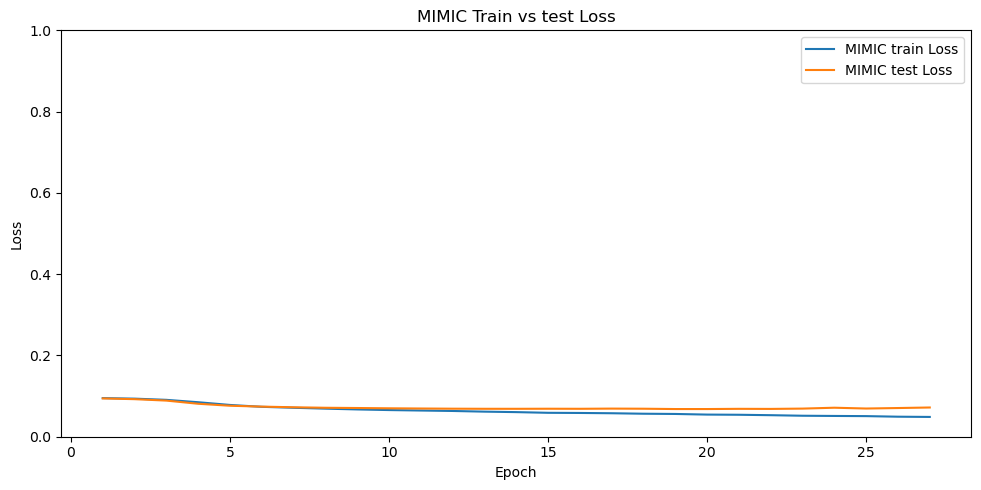

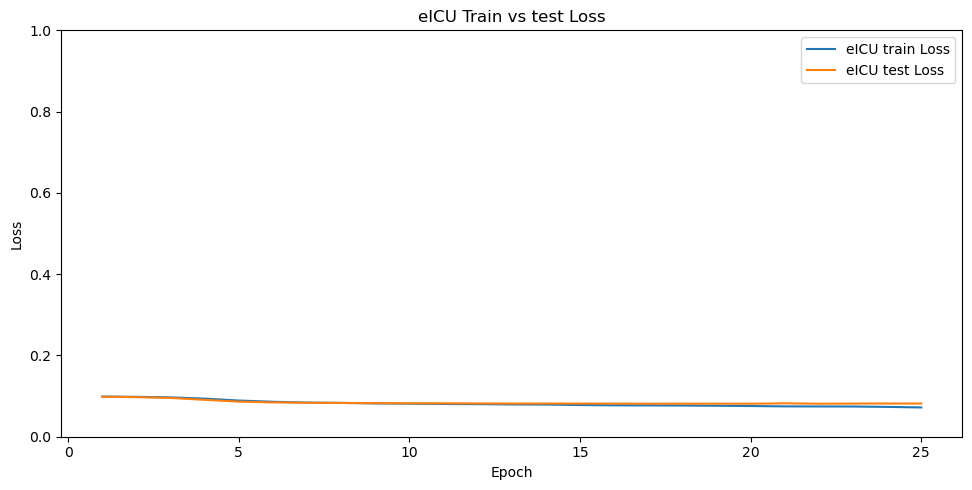

In [32]:
# === PLOT TRAINING & VALIDATION LOSS ===
epochs1 = list(range(1, len(history1['train_loss']) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs1, history1["train_loss"], label="MIMIC train Loss")
plt.plot(epochs1, history1["val_loss"], label="MIMIC test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MIMIC Train vs test Loss")
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.show()

epochs2 = list(range(1, len(history2['train_loss']) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs2, history2["train_loss"], label="eICU train Loss")
plt.plot(epochs2, history2["val_loss"], label="eICU test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("eICU Train vs test Loss")
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.show()


We use the same metrics for decompensation as for mortality, i.e., AUC-ROC and AUC-PR. Because we care about
per-instance (vs. per-patient) accuracy in this task, overall performance is computed as the micro-average over all predictions,
regardless of patient.

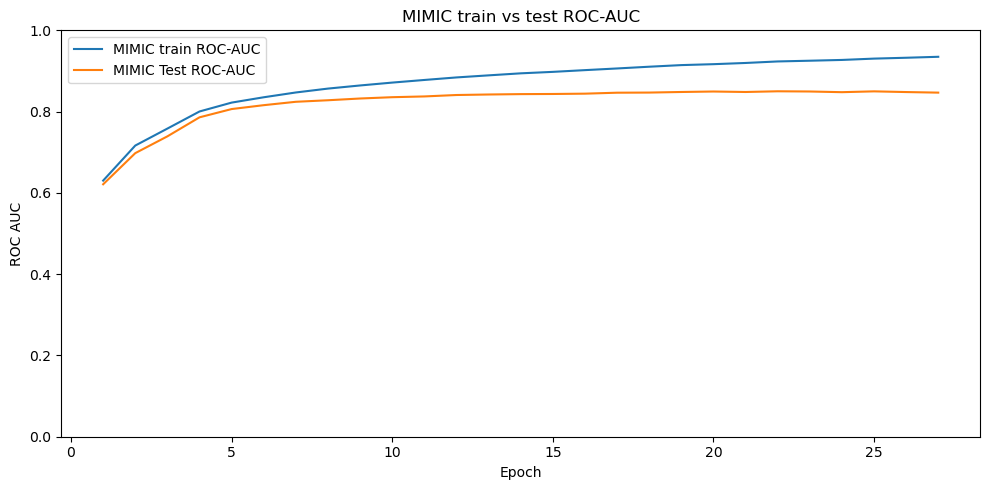

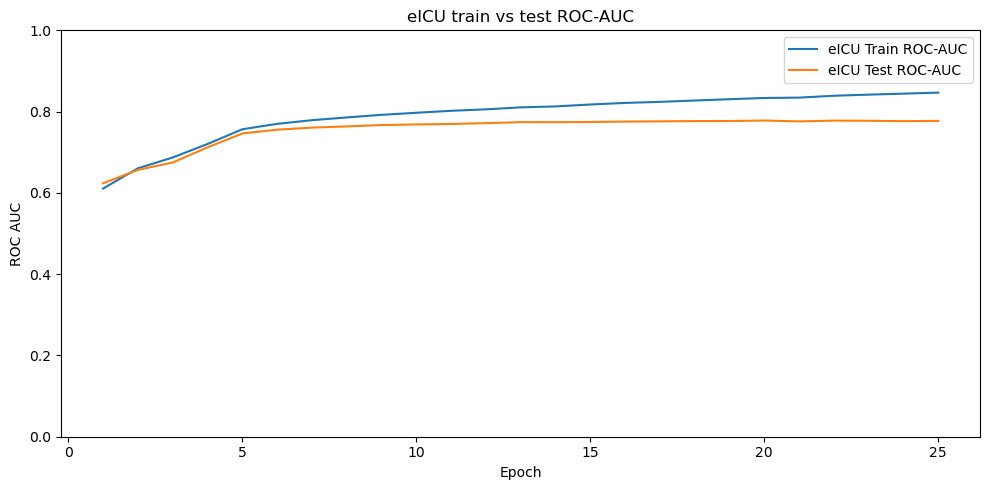

In [33]:
# === PLOT TRAINING & VALIDATION ROC-AUC ===
plt.figure(figsize=(10, 5))
plt.plot(epochs1, history1["train_auc"], label="MIMIC train ROC-AUC")
plt.plot(epochs1, history1["val_auc"], label="MIMIC Test ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("MIMIC train vs test ROC-AUC")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs2, history2["train_auc"], label="eICU Train ROC-AUC")
plt.plot(epochs2, history2["val_auc"], label="eICU Test ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("eICU train vs test ROC-AUC")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

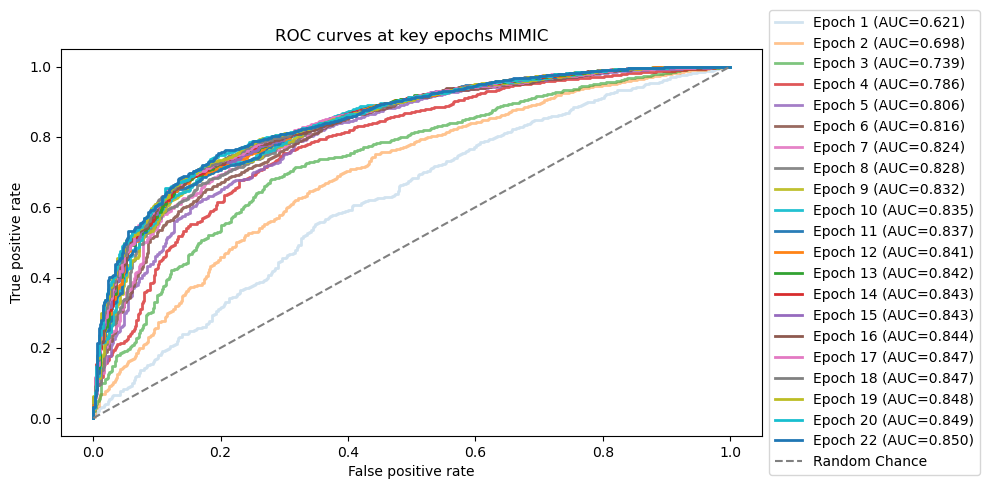

In [27]:
plt.figure(figsize=(10, 5))

plotted_aucs = []
for ep in sorted(roc_history1.keys()):
    if 0 <= ep - 1 < len(history1["val_auc"]):
        plotted_aucs.append(history1["val_auc"][ep - 1])

# AUC scaling for transparency
if plotted_aucs:
    min_auc = min(plotted_aucs)
    max_auc = max(plotted_aucs)
    min_alpha = 0.2
    max_alpha = 1.0
else:
    min_auc, max_auc = 0, 1
    min_alpha, max_alpha = 0.2, 1.0
for ep, (fpr, tpr) in sorted(roc_history1.items()):
    current_alpha = min_alpha # Default alpha if AUC not found or issues
    if 0 <= ep - 1 < len(history1["val_auc"]):
        auc_val = history1["val_auc"][ep-1]
        
        if max_auc == min_auc: # Avoid division by zero if all AUCs are the same
            current_alpha = max_alpha
        else:
            # Scale AUC to be between 0 and 1
            normalized_auc = (auc_val - min_auc) / (max_auc - min_auc)
            # Scale to be between min_alpha and max_alpha
            current_alpha = min_alpha + (normalized_auc * (max_alpha - min_alpha))
        
        label_text = f"Epoch {ep} (AUC={auc_val:.3f})"
    else:
        # Fallback if epoch number is out of bounds
        auc_val = "N/A" # For the label
        label_text = f"Epoch {ep} (AUC=N/A)"

    plt.plot(fpr, tpr, label=label_text, alpha=current_alpha, linewidth=2)

plt.plot([0,1], [0,1], "--", color="gray", label="Random Chance")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves at key epochs MIMIC") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Keep legend outside the plot
plt.tight_layout()
plt.show()

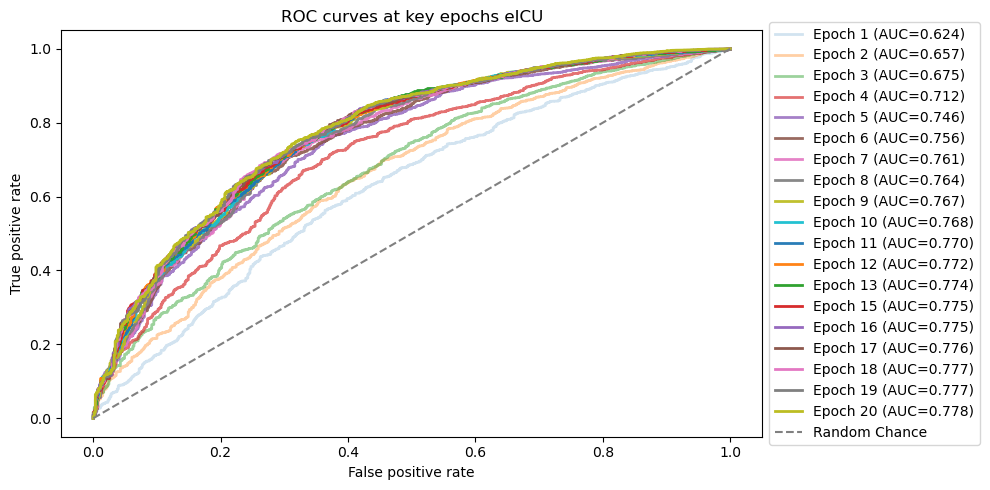

In [28]:
plt.figure(figsize=(10, 5))

plotted_aucs = []
for ep in sorted(roc_history2.keys()):
    if 0 <= ep - 1 < len(history2["val_auc"]):
        plotted_aucs.append(history2["val_auc"][ep - 1])

# AUC scaling for transparency
if plotted_aucs:
    min_auc = min(plotted_aucs)
    max_auc = max(plotted_aucs)
    min_alpha = 0.2
    max_alpha = 1.0
else:
    min_auc, max_auc = 0, 1
    min_alpha, max_alpha = 0.2, 1.0
for ep, (fpr, tpr) in sorted(roc_history2.items()):
    current_alpha = min_alpha # Default alpha if AUC not found or issues
    if 0 <= ep - 1 < len(history2["val_auc"]):
        auc_val = history2["val_auc"][ep-1]
        
        if max_auc == min_auc: # Avoid division by zero if all AUCs are the same
            current_alpha = max_alpha
        else:
            # Scale AUC to be between 0 and 1
            normalized_auc = (auc_val - min_auc) / (max_auc - min_auc)
            # Scale to be between min_alpha and max_alpha
            current_alpha = min_alpha + (normalized_auc * (max_alpha - min_alpha))
        
        label_text = f"Epoch {ep} (AUC={auc_val:.3f})"
    else:
        # Fallback if epoch number is out of bounds
        auc_val = "N/A" # For the label
        label_text = f"Epoch {ep} (AUC=N/A)"

    plt.plot(fpr, tpr, label=label_text, alpha=current_alpha, linewidth=2)

plt.plot([0,1], [0,1], "--", color="gray", label="Random Chance")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves at key epochs eICU") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Keep legend outside the plot
plt.tight_layout()
plt.show()